# Use Adam Classifier

## Objectives
- use the Adam Optimizer instead of Gradient Descent
- create a run_training function that will take the hyperparameters as variables and return the training and the testing error evolution over time as a list, suitable for plotting
- investigate the performance as function of the learning rate

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
tf.__version__

'0.12.1'

<img align="left" src="files/old.png"> **Load data**

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
xtr = data.train.images
ytr = data.train.labels

xte = data.test.images
yte = data.test.labels

xva = data.validation.images
yva = data.validation.labels

<img align="left" src="files/old.png"> **Convolutional layer**

In [5]:
def convolutional_layer(input, filter_size, in_channels, out_channels, conv_strides, pool_kernel, pool_strides):

    filter_shape = [filter_size, filter_size, in_channels, out_channels]
    biases_shape = [out_channels]
    
    filter = tf.Variable(tf.truncated_normal(filter_shape))
    biases = tf.Variable(tf.truncated_normal(biases_shape))
    
    result = tf.nn.conv2d(input, filter, strides=conv_strides, padding='SAME') + biases
    result = tf.nn.max_pool(value=result,ksize=pool_kernel,strides=pool_strides,padding='SAME')
    result = tf.nn.relu(result)
    
    return result

<img align="left" src="files/old.png"> **Flatten the layer**

In [6]:
def flatten_layer(input):
    
    layer_shape = input.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(input, [-1, num_features])
    
    return layer_flat, num_features

<img align="left" src="files/old.png"> **Fully connected layer**

In [7]:
def fully_connected_layer(input, num_features, num_outputs):
    
    weights = tf.Variable(tf.truncated_normal([num_features, num_outputs], stddev=0.05))
    biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))

    output = tf.matmul(input, weights) + biases
    
    return output

<img align="left" src="files/modified.png"> **Optimize:** pass the learning rate as a parameter

In [8]:
def optimize(optimizer, l_rate, iterations, x_train, y_train, batch_size):
    
    for i in range(0,iterations):  
        x1, x2, y1, y2 = train_test_split(x_train, y_train, train_size=batch_size, random_state=i)        
        sess.run(optimizer, feed_dict = {x: x1, y: y1, learning_rate: l_rate})

<img align="left" src="files/old.png"> **Test accuracy**

In [9]:
def test_accuracy(logits,x_data,y_data):
    
    y_pred = tf.nn.softmax(logits)
    
    y_pred_cls = tf.argmax(y_pred, dimension=1)
    y_true_cls = tf.argmax(y, dimension=1)

    prediction = tf.equal(y_pred_cls, y_true_cls)    
    
    num_examples = len(x_data)
    batch_size = 8192
    all_predictions = []
    
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = x_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        all_predictions.extend(sess.run(prediction, feed_dict = {x: batch_x, y: batch_y}))    
    
    return np.mean(all_predictions)

## Build the computational graph using the defined functions

In [10]:
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

learning_rate = tf.placeholder(tf.float32) 

x_2d = tf.reshape(x, [-1, 28, 28, 1])

conv_1_out = convolutional_layer(x_2d, 5, 1, 32, [1, 1, 1, 1], [1, 2, 2, 1], [1, 2, 2, 1])
conv_2_out = convolutional_layer(conv_1_out, 5, 32, 64, [1, 1, 1, 1], [1, 2, 2, 1], [1, 2, 2, 1])

layer_flat, num_features = flatten_layer(conv_2_out)

layer_1 = fully_connected_layer(layer_flat, num_features, 512)
layer_1 = tf.nn.relu(layer_1)
logits = fully_connected_layer(layer_1, 512, 10)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits,y)
cost = tf.reduce_mean(cross_entropy)

grad = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
adam = tf.train.AdamOptimizer(learning_rate).minimize(cost)

<img align="left" src="files/new.png"> **Train and test, return lists to print later**

In [11]:
def run_training(logits, optimizer, l_rate, tick_size, n_ticks, xtr, ytr, xte, yte, train_batch, verbose):
    
    sess.run(tf.global_variables_initializer())
    
    result = [[],[],[],0]

    for i in range(1,n_ticks+1):    
        optimize(optimizer, l_rate, tick_size, xtr, ytr, train_batch)        
        tr_a = test_accuracy(logits,xtr,ytr)
        te_a = test_accuracy(logits,xte,yte)
        result[0].append(tr_a)
        result[1].append(te_a)
        result[2].append(i*tick_size)
        if verbose:
            print i, tr_a, te_a
    result[3] = test_accuracy(logits,xva,yva)
    return result

In [12]:
sess = tf.Session()

In [13]:
batch = 512
tick = 1000
n_ticks = 20
verbose = 0

In [14]:
gr_r1, gr_e1, gr_t1, gr_v1 = run_training(logits, grad, 10**-2, tick, n_ticks, xtr, ytr, xte, yte, batch, verbose)

In [15]:
gr_r2, gr_e2, gr_t2, gr_v2 = run_training(logits, grad, 10**-3, tick, n_ticks, xtr, ytr, xte, yte, batch, verbose)

In [16]:
gr_r3, gr_e3, gr_t3, gr_v3 = run_training(logits, grad, 10**-4, tick, n_ticks, xtr, ytr, xte, yte, batch, verbose)

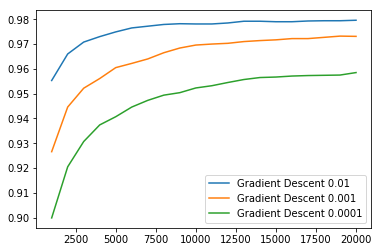

In [17]:
plt.plot(gr_t1,gr_e1, label='Gradient Descent 0.01')
plt.plot(gr_t2,gr_e2, label='Gradient Descent 0.001')
plt.plot(gr_t3,gr_e3, label='Gradient Descent 0.0001')
plt.legend()
plt.show()

In [18]:
ad_r1, ad_e1, ad_t1, ad_v1 = run_training(logits, adam, 10**-2, tick, n_ticks, xtr, ytr, xte, yte, batch, verbose)

In [19]:
ad_r2, ad_e2, ad_t2, ad_v2 = run_training(logits, adam, 10**-3, tick, n_ticks, xtr, ytr, xte, yte, batch, verbose)

In [20]:
ad_r3, ad_e3, ad_t3, ad_v3 = run_training(logits, adam, 10**-4, tick, n_ticks, xtr, ytr, xte, yte, batch, verbose)

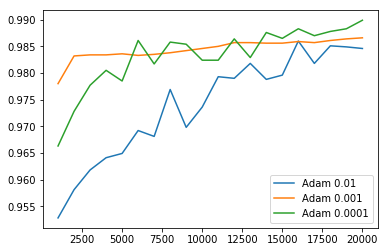

In [21]:
plt.plot(ad_t1,ad_e1, label='Adam 0.01')
plt.plot(ad_t2,ad_e2, label='Adam 0.001')
plt.plot(ad_t3,ad_e3, label='Adam 0.0001')
plt.legend()
plt.show()

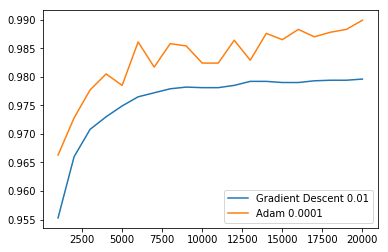

In [22]:
plt.plot(gr_t1,gr_e1, label='Gradient Descent 0.01')
plt.plot(ad_t3,ad_e3, label='Adam 0.0001')
plt.legend()
plt.show()

In [23]:
gr_v1, gr_v2, gr_v3

(0.9788, 0.97599999999999998, 0.96260000000000001)

In [24]:
ad_v1, ad_v2, ad_v3

(0.98799999999999999, 0.98980000000000001, 0.99099999999999999)